# Maximisation-expectation

Notebook configuration

In [1]:
from os import getcwd, chdir

# set the current working directory to the repository's root, if required
if getcwd().endswith('notebooks'):
    chdir('./../')

In [2]:
!python -m pip install tabulate
from IPython.display import display
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

def display_horizontaly_two_tables(df:pd.DataFrame,df2:pd.DataFrame, title1:str, title2:str):
    df_md = df.to_markdown().split('\n')
    df2_md = df2.to_markdown().split('\n')
    title_line = title1 + " " * (len(df_md[0])-len(title1)) + "\t" + title2
    two_tabs = "\n".join([title_line] + [df_md[i] + '\t' + df2_md[i] for i in range(len(df_md))])
    print(two_tabs)


[notice] A new release of pip is available: 23.1.2 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Initial Dataset

In [3]:
from data.getDataset import getCognatesSet, getIteration
from data.vocab import computeInferenceData_Samples, computeInferenceData_Cognates, wordsToOneHots, vocabulary, IPA_charsNumber
from models.types import ModernLanguages, MODERN_LANGUAGES, InferenceData_Cognates
from Source.reconstructionModel import ReconstructionModel

raw_cognates = getCognatesSet()
cognates: dict[ModernLanguages, InferenceData_Cognates] = computeInferenceData_Cognates({lang: wordsToOneHots(raw_cognates[lang]) for lang in raw_cognates})
raw_samples = getIteration(1)
currentReconstructions = computeInferenceData_Samples(wordsToOneHots(raw_samples)) #TODO: simplify the data loading

LSTM_INPUT_DIM = 50
LSTM_HIDDEN_DIM = 50

randomEditModel = ReconstructionModel(MODERN_LANGUAGES, vocabulary, LSTM_INPUT_DIM, LSTM_HIDDEN_DIM)

TEST_LANGUAGE:ModernLanguages = "french"
x_maxLength = currentReconstructions[0].size()[0] - 2
y_maxLength = cognates[TEST_LANGUAGE][0].size()[0] - 2
print('|y| max =', y_maxLength)
print('|x| max =', x_maxLength)

|y| max = 17
|x| max = 16


## Backward dynamic Program

Backward dynamic Program

In [4]:
targets_prob = randomEditModel.backward_dynProg(currentReconstructions, cognates)

### Analysis

Test on $x :=$`"absyrdʊ"` and $y :=$`"absˈyʁd"` ($|x|=7$ and $|y|=7$)

In [5]:
IDX = 20 # the index in the batch of the sample to be studied
x_length, y_length = 7, 7

backward_prob_dlt = targets_prob[TEST_LANGUAGE].dlt[:,:,IDX].cpu().numpy().squeeze(-1)
backward_prob_end = targets_prob[TEST_LANGUAGE].end[:,:,IDX].cpu().numpy().squeeze(-1)
backward_prob_sub = targets_prob[TEST_LANGUAGE].sub[:,:,IDX].cpu().numpy().squeeze(-1)
backward_prob_ins = targets_prob[TEST_LANGUAGE].ins[:,:,IDX].cpu().numpy().squeeze(-1)

#### Display of cached probabilities for the substitution and the deletion operations

Notice that the logarithmic probabilities that have not to be defined for these operations are automatically set to $-\infty{}$ thanks to the recurrence mathematical relations of the backward dynamic program. So do the undefined probabilities in padding positions, thanks to the neutrality of edit model's cached inference probabilities (which equal $0$ in the log space).

In [6]:
df = pd.DataFrame(backward_prob_sub[:x_length+2, :y_length+2])
df2 = pd.DataFrame(backward_prob_dlt[:x_length+2, :y_length+2])

display_horizontaly_two_tables(df, df2, "Subsitution Operation", "Deletion Operation")

Subsitution Operation                                                                                	Deletion Operation
|    |        0 |        1 |        2 |        3 |        4 |        5 |        6 |      7 |      8 |	|    |        0 |        1 |        2 |        3 |        4 |        5 |        6 |         7 |      8 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|-------:|-------:|	|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|----------:|-------:|
|  0 | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -2e+09 | -2e+09 |	|  0 | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09    | -2e+09 |
|  1 | -1.51798 | -1.88173 | -2.54069 | -3.80331 | -4.75765 | -5.92727 | -7.92382 | -1e+09 | -1e+09 |	|  1 | -1.64449 | -1.83681 | -2.17258 | -3.54944 | -4.46258 | -4.95848 | -6.30866 | -7.9257   | -1e+09 |
|  2 | -2.19113 | -2.0138  | -2.11091 | -2.85484 | 

## Target probs transformation for the training dataset

In [7]:
from Source.utils import dl_to_ld
from models.types import Operations
from torch import Tensor
for lang in targets_prob.keys():
    targets_prob[lang] = targets_prob[lang].toTargetsProbs()
targets_prob: list[dict[ModernLanguages, dict[Operations, Tensor]]] = dl_to_ld(targets_prob) #type: ignore

In [8]:
renderedTargets = targets_prob[IDX][TEST_LANGUAGE]
df_renderedSub = pd.DataFrame(renderedTargets['sub'].squeeze(-1).squeeze(-1)[:x_length+2, :y_length+2])
df2_renderedDlt = pd.DataFrame(renderedTargets['dlt'].squeeze(-1).squeeze(-1)[:x_length+2, :y_length+2])
display_horizontaly_two_tables(df_renderedSub, df2_renderedDlt, "Subsitution Operation", "Deletion Operation")

Subsitution Operation                                                                             	Deletion Operation
|    |        0 |        1 |        2 |        3 |        4 |        5 |        6 |      7 |   8 |	|    |        0 |        1 |        2 |        3 |        4 |        5 |        6 |         7 |   8 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|-------:|----:|	|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|----------:|----:|
|  0 | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -2e+09 |   0 |	|  0 | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09    |   0 |
|  1 | -1.51798 | -1.88173 | -2.54069 | -3.80331 | -4.75765 | -5.92727 | -7.92382 | -1e+09 |   0 |	|  1 | -1.64449 | -1.83681 | -2.17258 | -3.54944 | -4.46258 | -4.95848 | -6.30866 | -7.9257   |   0 |
|  2 | -2.19113 | -2.0138  | -2.11091 | -2.85484 | -3.33378 | -4.2885  | -6.09

## DataLoader initialisation

In [9]:
from data.reconstruction_datasets import trainingDataLoader

MINI_BATCH_SIZE = 30
NUM_WORKERS = 1
dl = trainingDataLoader(raw_samples, dl_to_ld(raw_cognates), targets_prob, MINI_BATCH_SIZE, NUM_WORKERS)

## Training round

Epoch 1
------------------------------------------------------------
Average loss: -1.533140 ; Standard deviation: 1.383988          
------------------------------------------------------------

Epoch 2
------------------------------------------------------------
Average loss: -2.871263 ; Standard deviation: 0.483915          
------------------------------------------------------------

Epoch 3
------------------------------------------------------------
Average loss: -3.234866 ; Standard deviation: 0.567194          
------------------------------------------------------------

Epoch 4
------------------------------------------------------------
Average loss: -3.443805 ; Standard deviation: 0.567601          
------------------------------------------------------------

Epoch 5
------------------------------------------------------------
Average loss: -3.567517 ; Standard deviation: 0.615346          
------------------------------------------------------------

Figure(640x480)


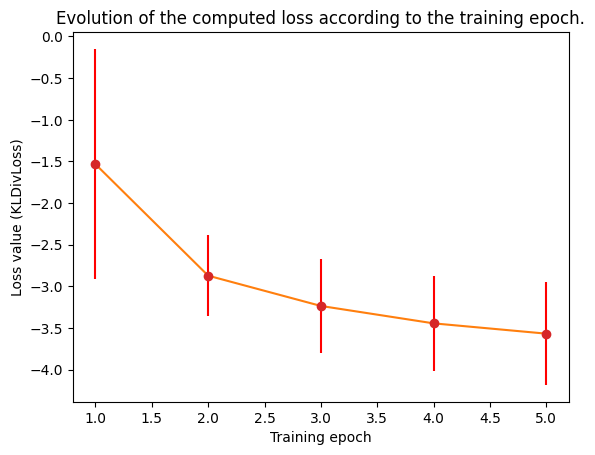

In [10]:
EPOCHS, LEARNING_RATE = 5, 0.01
randomEditModel.train_models(dl, EPOCHS, LEARNING_RATE)